In [1]:
import os, sys, re
import numpy as np
import pandas as pd
import platform
from IPython.display import display, clear_output, HTML
from datetime import datetime
import pickle

from time import sleep
from tqdm.auto import tqdm

import selenium
from selenium.webdriver.common.by import By
from selenium.webdriver import Firefox, ActionChains

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

START_TS = datetime.now()

In [2]:
from utils import get_all_elements, iou_xywh, screenshot, maximize_window, get_parents_list, build_tree_dict, DatasetBuilder

2021-03-02 06:47:32,157 - INFO - dataset:dataset.py:19 - dataset package is loaded...


In [3]:
selenium.__version__

'3.141.0'

## Parameters

In [4]:
SITE_ROOT = 'https://jdi-testing.github.io/jdi-light/'
LOGIN = 'Roman'
PASSWORD = 'Jdi1234'
SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
HEADLESS = True #False


## Create driver (HEADLESS={True|False})

In [5]:
from selenium.webdriver.chrome.options import Options
options = Options()
options.add_argument('--disable-gpu')  # Last I checked this was necessary.
options.add_argument('--headless')

CHROME_DRIVER_PATH = os.path.join(os.getcwd(), 'chromedriver.exe')
if os.path.exists(CHROME_DRIVER_PATH):
    driver = selenium.webdriver.Chrome(executable_path=CHROME_DRIVER_PATH, options=options)
    driver.get(SITE_ROOT)


In [6]:
driver.get_window_position(), driver.get_window_size(), driver.title

({'x': 0, 'y': 0}, {'width': 800, 'height': 600}, 'Home Page')

In [7]:
re.findall('<[A-Za-z]+ [^<>]*>', driver.page_source)

['<html lang="en">',
 '<meta charset="utf-8">',
 '<meta http-equiv="X-UA-Compatible" content="IE=edge">',
 '<meta name="viewport" content="width=device-width">',
 '<link rel="stylesheet" href="bootstrap/css/bootstrap.min.css">',
 '<link rel="stylesheet" href="css/uui-all.css">',
 '<link rel="stylesheet" href="css/custom-styles.css">',
 '<link rel="stylesheet" href="fonts/font-awesome/css/font-awesome.min.css">',
 '<link rel="stylesheet" href="css/lib/components/jquery.mCustomScrollbar.css">',
 '<script src="js/lib/jquery-1.11.1.min.js">',
 '<script src="js/lib/components/jquery.mCustomScrollbar.concat.min.js">',
 '<script src="js/lib/jquery.cookie.js">',
 '<script src="bootstrap/js/bootstrap.min.js">',
 '<script src="js/uui-core.min.js" type="text/javascript">',
 '<script src="js/utils.js" type="text/javascript">',
 '<script src="js/lib/html5shiv.js">',
 '<script src="js/lib/respond.min.js">',
 '<div class="uui-header dark-gray">',
 '<nav role="navigation">',
 '<div class="sidebar-togg

In [8]:
[(e.tag_name, e.is_displayed(), e.id) for e in driver.find_elements_by_xpath('//*') if e.tag_name == 'span']

[('span', False, '2f9ca318-10e2-4202-bebe-d3e7455fdec8'),
 ('span', True, '6661a86f-e7e5-4aed-971d-82c95b574565'),
 ('span', True, '73019122-6753-4189-a832-69c3af56b697'),
 ('span', False, 'd9e4b984-959a-4a84-9d4c-c41f26ab9d75'),
 ('span', True, '698aa0f1-1822-4f3a-83b2-2f14502a4976'),
 ('span', False, '41f0f9e1-0fe4-4caa-9d56-89dfc0f9b222'),
 ('span', False, '7d266e46-e444-46ba-aa1d-6d8d0addc916'),
 ('span', False, 'd5afcf6d-86ea-45f5-a526-aa1b053fe40e'),
 ('span', True, '939c0449-dd1e-4502-881e-ee949aff7621'),
 ('span', False, '92cc67e3-a0f1-4164-b1ca-e1df8da76603'),
 ('span', False, '734cc4dd-e538-4a81-bdc6-8357c880f758'),
 ('span', True, 'a017fd9f-7207-483f-83ad-757fcbf764f6'),
 ('span', True, '3aa6292f-2a90-4a9f-a92f-74ba7eac79fe'),
 ('span', True, 'a5a8e372-2a90-4ec9-a753-7ccf8e6c9b95'),
 ('span', False, 'b8ff2457-df69-4e99-8464-12b50fda4f2d'),
 ('span', False, '14fd4810-08e4-4be2-862c-9001c2132f73'),
 ('span', False, '32f648bd-89ac-43b4-8848-eaba793be0fa'),
 ('span', False, '31f

In [9]:
e = [e for e in driver.find_elements_by_xpath('//*') if e.tag_name == 'span'][1]

In [10]:
import io

In [11]:
buf = io.BytesIO(e.screenshot_as_png)

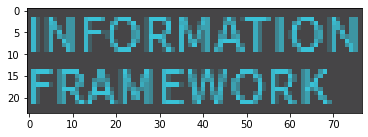

In [12]:
plt.imshow(plt.imread(buf))

In [13]:
driver.close()

In [14]:
os.makedirs('dataset/images', exist_ok=True)
os.makedirs('dataset/df', exist_ok=True)
os.makedirs('dataset/annotations', exist_ok=True)
os.makedirs('dataset/html', exist_ok=True)


## Setup (init web driver, login)

In [15]:
def setup_web_driver():
    
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')

    CHROME_DRIVER_PATH = os.path.join(os.getcwd(), 'chromedriver.exe')
    if os.path.exists(CHROME_DRIVER_PATH):
        driver = selenium.webdriver.Chrome(executable_path=CHROME_DRIVER_PATH, options=options)
        driver.get(SITE_ROOT)
    
    driver.find_element_by_id("user-icon").click()
    driver.find_element_by_id("name").send_keys(LOGIN)
    driver.find_element_by_id("password").send_keys(PASSWORD)
    driver.find_element_by_id("login-button").click()
    sleep(WAIT_TIME_SECONDS)
        
    return driver
    

2021-03-02 06:47:38,338 - INFO - dataset:dataset.py:172 - Dataset name: login
2021-03-02 06:47:38,338 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 06:47:38,338 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 06:47:39,439 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 06:47:39,439 - INFO - <ipython-input-16-ae9373fd3607>:<ipython-input-16-ae9373fd3607>:4 - getting page
2021-03-02 06:47:47,505 - INFO - common:common.py:82 - Window maximized
2021-03-02 06:47:47,505 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/login.png
2021-03-02 06:47:47,805 - INFO - dataset:dataset.py:247 - Save html to dataset/html/login.html
Number of discovered elements: 228
2021-03-02 06:47:47,821 - INFO - common:common.py:363 - collect features: text
2021-03-02 06:47:49,524 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 06:47:51,396 - INFO - common:common.py:370 - collect features: ele

Mouse hover checking:   0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

2021-03-02 06:48:48,943 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/login.parquet
2021-03-02 06:48:48,961 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 06:48:48,961 - INFO - dataset:dataset.py:49 - Leafs set size: 99 (nodes which have no children)
2021-03-02 06:48:48,961 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 06:48:48,977 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 71 (nodes which have leafs as children)
2021-03-02 06:48:48,977 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 06:48:48,977 - INFO - dataset:dataset.py:59 - Nodes with children: 130
2021-03-02 06:48:48,977 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 06:48:48,977 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 06:48:48,977 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 06:48:49,043 - INFO -

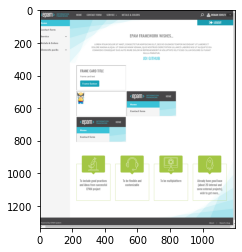

In [16]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        maximize_window(driver=driver)

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='login') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/login.png'))
    pass

# with setup_web_driver() as driver:
#     maximize_window(driver=driver)
#     plt.imshow(screenshot(driver, save_to_file='dataset/images/login.png'))
#     elements_df = get_all_elements(driver=driver)
#     elements_df.to_parquet('dataset/df/login.parquet')
#     with open('dataset/html/login.html', 'w') as f:
#         f.write(driver.page_source)
#         f.flush()
# display(elements_df)


In [17]:
elements_df.attr_class.unique()

array(['', 'uui-header dark-gray', 'sidebar-toggle-box blue',
       'sidebar-tooltip', 'fa fa-reorder', 'epam-logo',
       'uui-navigation nav navbar-nav m-l8', 'dropdown',
       'dropdown-toggle', 'caret', 'dropdown-menu',
       'uui-navigation navbar-nav navbar-right',
       'dropdown uui-profile-menu open', 'profile-photo',
       'dropdown-menu dropdown-menu-login',
       'form-horizontal login hidden', 'form-horizontal-pad',
       'form-group form-group10', 'col-sm-3', 'col-sm-9',
       'uui-form-element', 'login-txt hidden',
       'uui-button dark-blue btn-login', 'fa fa-sign-in', 'logout',
       'fa fa-sign-out', 'search', 'icon-search', 'search-active hidden',
       'search-title', 'icon-search active', 'search-field', 'wrapper',
       'uui-side-bar mCustomScrollbar _mCS_1 mCS_no_scrollbar',
       'mCustomScrollBox mCS-light mCSB_vertical mCSB_inside',
       'mCSB_container mCS_y_hidden mCS_no_scrollbar_y', 'sidebar-menu',
       'active', 'menu-title', 'fa fa-car

In [18]:
elements_df.attr_role.unique()

array([None, 'navigation', 'menu'], dtype=object)

In [19]:
elements_df.attr_onclick.unique()

array([None, "window.open('search.html','_self')"], dtype=object)

In [20]:
elements_df.attr_type.unique()

array([None, '', 'text/javascript', 'text', 'password', 'submit'],
      dtype=object)

# Save pages & screenshots

- ## HTML 5

2021-03-02 06:48:49,290 - INFO - dataset:dataset.py:172 - Dataset name: html-5
2021-03-02 06:48:49,290 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 06:48:49,290 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 06:48:50,421 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 06:48:50,421 - INFO - <ipython-input-21-3d6e66093da3>:<ipython-input-21-3d6e66093da3>:4 - getting page
2021-03-02 06:48:59,007 - INFO - common:common.py:82 - Window maximized
2021-03-02 06:49:06,018 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/html-5.png
2021-03-02 06:49:06,639 - INFO - dataset:dataset.py:247 - Save html to dataset/html/html-5.html
Number of discovered elements: 662
2021-03-02 06:49:06,672 - INFO - common:common.py:363 - collect features: text
2021-03-02 06:49:13,007 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 06:49:19,561 - INFO - common:common.py:370 - collect features: 

Mouse hover checking:   0%|          | 0/662 [00:00<?, ?it/s]

  0%|          | 0/662 [00:00<?, ?it/s]

2021-03-02 06:57:03,294 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/html-5.parquet
2021-03-02 06:57:03,310 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 06:57:03,312 - INFO - dataset:dataset.py:49 - Leafs set size: 412 (nodes which have no children)
2021-03-02 06:57:03,313 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 06:57:03,315 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 164 (nodes which have leafs as children)
2021-03-02 06:57:03,317 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 06:57:03,318 - INFO - dataset:dataset.py:59 - Nodes with children: 251
2021-03-02 06:57:03,319 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 06:57:03,319 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 06:57:03,319 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 06:57:03,507 - INF

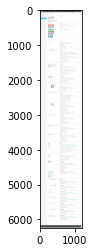

In [21]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element(By.LINK_TEXT, "Elements packs").click()
        driver.find_element(By.LINK_TEXT, "HTML 5").click()
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)
        

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='html-5') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/html-5.png'))
    pass



- ## Contact form

2021-03-02 06:57:03,828 - INFO - dataset:dataset.py:172 - Dataset name: contact-form
2021-03-02 06:57:03,828 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 06:57:03,833 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 06:57:04,957 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 06:57:04,957 - INFO - <ipython-input-22-72879830ee0e>:<ipython-input-22-72879830ee0e>:4 - getting page
2021-03-02 06:57:15,943 - INFO - common:common.py:82 - Window maximized
2021-03-02 06:57:22,950 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/contact-form.png
2021-03-02 06:57:23,206 - INFO - dataset:dataset.py:247 - Save html to dataset/html/contact-form.html
Number of discovered elements: 336
2021-03-02 06:57:23,221 - INFO - common:common.py:363 - collect features: text
2021-03-02 06:57:25,976 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 06:57:28,869 - INFO - common:common.py:370 - 

Mouse hover checking:   0%|          | 0/336 [00:00<?, ?it/s]

  0%|          | 0/336 [00:00<?, ?it/s]

2021-03-02 06:59:31,877 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/contact-form.parquet
2021-03-02 06:59:31,877 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 06:59:31,877 - INFO - dataset:dataset.py:49 - Leafs set size: 153 (nodes which have no children)
2021-03-02 06:59:31,877 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 06:59:31,893 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 98 (nodes which have leafs as children)
2021-03-02 06:59:31,893 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 06:59:31,893 - INFO - dataset:dataset.py:59 - Nodes with children: 184
2021-03-02 06:59:31,893 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 06:59:31,893 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 06:59:31,893 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 06:59:31,941 

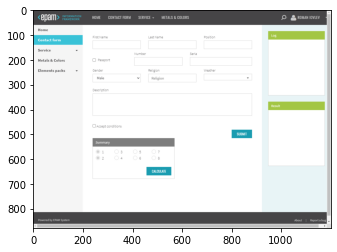

In [22]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element(By.LINK_TEXT, "Contact form").click()
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)        

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='contact-form') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/contact-form.png'))
    pass


- ## Mobile and HTML 5

2021-03-02 06:59:32,109 - INFO - dataset:dataset.py:172 - Dataset name: mobile-and-html-5
2021-03-02 06:59:32,109 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 06:59:32,109 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 06:59:33,230 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 06:59:33,230 - INFO - <ipython-input-23-783cf8094e2f>:<ipython-input-23-783cf8094e2f>:4 - getting page
2021-03-02 06:59:48,809 - INFO - common:common.py:82 - Window maximized
2021-03-02 06:59:55,810 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/mobile-and-html-5.png
2021-03-02 06:59:56,422 - INFO - dataset:dataset.py:247 - Save html to dataset/html/mobile-and-html-5.html
Number of discovered elements: 647
2021-03-02 06:59:56,470 - INFO - common:common.py:363 - collect features: text
2021-03-02 07:00:02,262 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 07:00:08,543 - INFO - common:c

Mouse hover checking:   0%|          | 0/647 [00:00<?, ?it/s]

  0%|          | 0/647 [00:00<?, ?it/s]

2021-03-02 07:07:40,313 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/mobile-and-html-5.parquet
2021-03-02 07:07:40,313 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 07:07:40,313 - INFO - dataset:dataset.py:49 - Leafs set size: 397 (nodes which have no children)
2021-03-02 07:07:40,313 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 07:07:40,313 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 164 (nodes which have leafs as children)
2021-03-02 07:07:40,313 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 07:07:40,313 - INFO - dataset:dataset.py:59 - Nodes with children: 251
2021-03-02 07:07:40,329 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 07:07:40,329 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 07:07:40,329 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 07:07:4

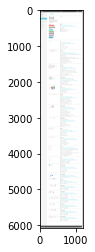

In [23]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Elements packs").click()
        driver.find_element_by_link_text("Mobile and HTML 5").click()
        sleep(WAIT_TIME_SECONDS)
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='mobile-and-html-5') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/mobile-and-html-5.png'))
    pass
    


- ## Bootstrap

2021-03-02 07:07:40,826 - INFO - dataset:dataset.py:172 - Dataset name: bootstrap
2021-03-02 07:07:40,826 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 07:07:40,826 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 07:07:41,948 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 07:07:41,949 - INFO - <ipython-input-24-d888ee62de07>:<ipython-input-24-d888ee62de07>:4 - getting page
2021-03-02 07:08:00,138 - INFO - common:common.py:82 - Window maximized
2021-03-02 07:08:07,144 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/bootstrap.png
2021-03-02 07:08:07,902 - INFO - dataset:dataset.py:247 - Save html to dataset/html/bootstrap.html
Number of discovered elements: 1095
2021-03-02 07:08:07,982 - INFO - common:common.py:363 - collect features: text
2021-03-02 07:08:19,558 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 07:08:32,400 - INFO - common:common.py:370 - collect 

Mouse hover checking:   0%|          | 0/1095 [00:00<?, ?it/s]

  0%|          | 0/1095 [00:00<?, ?it/s]

2021-03-02 07:24:07,496 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/bootstrap.parquet
2021-03-02 07:24:07,504 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 07:24:07,505 - INFO - dataset:dataset.py:49 - Leafs set size: 535 (nodes which have no children)
2021-03-02 07:24:07,506 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 07:24:07,509 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 372 (nodes which have leafs as children)
2021-03-02 07:24:07,511 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 07:24:07,512 - INFO - dataset:dataset.py:59 - Nodes with children: 561
2021-03-02 07:24:07,513 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 07:24:07,517 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 07:24:07,520 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 07:24:07,766 - 

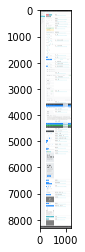

In [24]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Elements packs").click()
        driver.find_element_by_link_text("Bootstrap").click()
        sleep(WAIT_TIME_SECONDS)
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='bootstrap') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/bootstrap.png'))
    pass


- ## React Ant

2021-03-02 07:24:08,114 - INFO - dataset:dataset.py:172 - Dataset name: react-ant
2021-03-02 07:24:08,114 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 07:24:08,114 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 07:24:09,166 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 07:24:09,166 - INFO - <ipython-input-25-208f12a08202>:<ipython-input-25-208f12a08202>:4 - getting page
2021-03-02 07:24:34,872 - INFO - common:common.py:82 - Window maximized
2021-03-02 07:24:41,876 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/react-ant.png
2021-03-02 07:24:42,234 - INFO - dataset:dataset.py:247 - Save html to dataset/html/react-ant.html
Number of discovered elements: 700
2021-03-02 07:24:42,318 - INFO - common:common.py:363 - collect features: text
2021-03-02 07:24:49,584 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 07:24:56,892 - INFO - common:common.py:370 - collect f

Mouse hover checking:   0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

2021-03-02 07:33:44,462 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/react-ant.parquet
2021-03-02 07:33:44,478 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 07:33:44,478 - INFO - dataset:dataset.py:49 - Leafs set size: 260 (nodes which have no children)
2021-03-02 07:33:44,478 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 07:33:44,478 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 198 (nodes which have leafs as children)
2021-03-02 07:33:44,478 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 07:33:44,478 - INFO - dataset:dataset.py:59 - Nodes with children: 441
2021-03-02 07:33:44,478 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 07:33:44,493 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 07:33:44,493 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 07:33:44,563 - 

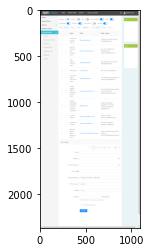

In [25]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Elements packs").click()
        driver.find_element_by_link_text("React Ant").click()
        sleep(WAIT_TIME_SECONDS)
        driver.maximize_window()
        sleep(WAIT_TIME_SECONDS)
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)
        
with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='react-ant') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/react-ant.png'))
    pass  


- ## Metals & Colors

2021-03-02 07:33:44,810 - INFO - dataset:dataset.py:172 - Dataset name: metals-and-colors
2021-03-02 07:33:44,810 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 07:33:44,810 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 07:33:45,881 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 07:33:45,881 - INFO - <ipython-input-26-fe49229b193d>:<ipython-input-26-fe49229b193d>:4 - getting page
2021-03-02 07:33:56,920 - INFO - common:common.py:82 - Window maximized
2021-03-02 07:34:03,931 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/metals-and-colors.png
2021-03-02 07:34:04,182 - INFO - dataset:dataset.py:247 - Save html to dataset/html/metals-and-colors.html
Number of discovered elements: 373
2021-03-02 07:34:04,260 - INFO - common:common.py:363 - collect features: text
2021-03-02 07:34:07,288 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 07:34:10,626 - INFO - common:c

Mouse hover checking:   0%|          | 0/373 [00:00<?, ?it/s]

  0%|          | 0/373 [00:00<?, ?it/s]

2021-03-02 07:36:07,554 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/metals-and-colors.parquet
2021-03-02 07:36:07,554 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 07:36:07,563 - INFO - dataset:dataset.py:49 - Leafs set size: 168 (nodes which have no children)
2021-03-02 07:36:07,564 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 07:36:07,565 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 107 (nodes which have leafs as children)
2021-03-02 07:36:07,567 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 07:36:07,568 - INFO - dataset:dataset.py:59 - Nodes with children: 206
2021-03-02 07:36:07,569 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 07:36:07,571 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 07:36:07,576 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 07:36:0

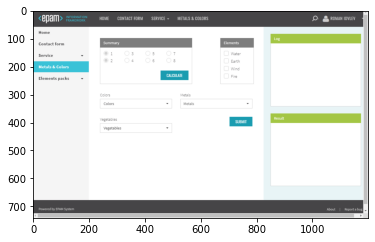

In [26]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Metals & Colors").click()
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='metals-and-colors') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/metals-and-colors.png'))
    pass


- ## Service / Support

2021-03-02 07:36:07,770 - INFO - dataset:dataset.py:172 - Dataset name: support
2021-03-02 07:36:07,770 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 07:36:07,770 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 07:36:08,878 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 07:36:08,878 - INFO - <ipython-input-27-9a44964303a9>:<ipython-input-27-9a44964303a9>:4 - getting page
2021-03-02 07:36:17,492 - INFO - common:common.py:82 - Window maximized
2021-03-02 07:36:24,497 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/support.png
2021-03-02 07:36:24,749 - INFO - dataset:dataset.py:247 - Save html to dataset/html/support.html
Number of discovered elements: 284
2021-03-02 07:36:24,765 - INFO - common:common.py:363 - collect features: text
2021-03-02 07:36:27,103 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 07:36:29,492 - INFO - common:common.py:370 - collect feature

Mouse hover checking:   0%|          | 0/284 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

2021-03-02 07:38:16,980 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/support.parquet
2021-03-02 07:38:16,995 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 07:38:16,995 - INFO - dataset:dataset.py:49 - Leafs set size: 127 (nodes which have no children)
2021-03-02 07:38:17,002 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 07:38:17,002 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 89 (nodes which have leafs as children)
2021-03-02 07:38:17,002 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 07:38:17,002 - INFO - dataset:dataset.py:59 - Nodes with children: 158
2021-03-02 07:38:17,002 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 07:38:17,002 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 07:38:17,002 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 07:38:17,041 - INF

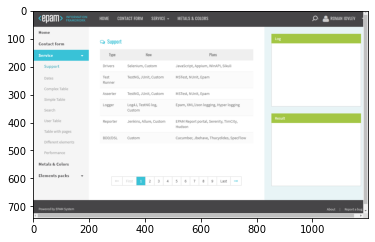

In [27]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Service").click()
        driver.find_element_by_link_text("Support").click()
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='support') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/support.png'))
    pass
    


- ## Service / Dates

2021-03-02 07:38:17,198 - INFO - dataset:dataset.py:172 - Dataset name: dates
2021-03-02 07:38:17,202 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 07:38:17,202 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 07:38:18,320 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 07:38:18,320 - INFO - <ipython-input-28-238fac39dd30>:<ipython-input-28-238fac39dd30>:4 - getting page
2021-03-02 07:38:26,925 - INFO - common:common.py:82 - Window maximized
2021-03-02 07:38:33,936 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/dates.png
2021-03-02 07:38:34,189 - INFO - dataset:dataset.py:247 - Save html to dataset/html/dates.html
Number of discovered elements: 313
2021-03-02 07:38:34,220 - INFO - common:common.py:363 - collect features: text
2021-03-02 07:38:36,779 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 07:38:39,516 - INFO - common:common.py:370 - collect features: ele

Mouse hover checking:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

2021-03-02 07:40:43,976 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/dates.parquet
2021-03-02 07:40:43,976 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 07:40:43,976 - INFO - dataset:dataset.py:49 - Leafs set size: 137 (nodes which have no children)
2021-03-02 07:40:43,976 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 07:40:43,976 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 100 (nodes which have leafs as children)
2021-03-02 07:40:43,976 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 07:40:43,976 - INFO - dataset:dataset.py:59 - Nodes with children: 177
2021-03-02 07:40:43,976 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 07:40:43,992 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 07:40:43,992 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 07:40:44,030 - INFO

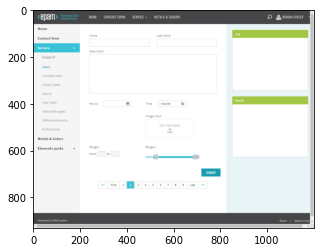

In [28]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Service").click()
        driver.find_element_by_link_text("Dates").click()
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='dates') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/dates.png'))
    pass


# with setup_web_driver() as driver:
      
#     driver.find_element_by_link_text("Service").click()
#     driver.find_element_by_link_text("Dates").click()
#     maximize_window(driver=driver)
#     sleep(WAIT_TIME_SECONDS)
    
#     plt.imshow(screenshot(driver, save_to_file='dataset/images/dates.png'))
#     elements_df = get_all_elements(driver=driver)
#     elements_df.to_parquet('dataset/df/dates.parquet')
    
#     with open('dataset/html/dates.html', 'wb') as f:
#         f.write(driver.page_source.encode())
#         f.flush()
    


- ## Service / Complex Table

2021-03-02 07:40:44,214 - INFO - dataset:dataset.py:172 - Dataset name: complex-table
2021-03-02 07:40:44,214 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 07:40:44,214 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 07:40:45,349 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 07:40:45,349 - INFO - <ipython-input-29-e462596fde9e>:<ipython-input-29-e462596fde9e>:4 - getting page
2021-03-02 07:40:58,915 - INFO - common:common.py:82 - Window maximized
2021-03-02 07:41:05,920 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/complex-table.png
2021-03-02 07:41:06,157 - INFO - dataset:dataset.py:247 - Save html to dataset/html/complex-table.html
Number of discovered elements: 423
2021-03-02 07:41:06,188 - INFO - common:common.py:363 - collect features: text
2021-03-02 07:41:09,943 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 07:41:13,752 - INFO - common:common.py:370

Mouse hover checking:   0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/423 [00:00<?, ?it/s]

2021-03-02 07:44:54,642 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/complex-table.parquet
2021-03-02 07:44:54,642 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 07:44:54,657 - INFO - dataset:dataset.py:49 - Leafs set size: 205 (nodes which have no children)
2021-03-02 07:44:54,658 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 07:44:54,660 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 130 (nodes which have leafs as children)
2021-03-02 07:44:54,662 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 07:44:54,662 - INFO - dataset:dataset.py:59 - Nodes with children: 219
2021-03-02 07:44:54,664 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 07:44:54,664 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 07:44:54,664 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 07:44:54,69

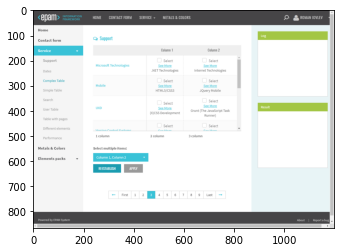

In [29]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Service").click()
        driver.find_element_by_link_text("Complex Table").click()
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='complex-table') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/complex-table.png'))
    pass



- ## Service / Search

2021-03-02 07:44:54,874 - INFO - dataset:dataset.py:172 - Dataset name: search
2021-03-02 07:44:54,874 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 07:44:54,874 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 07:44:55,975 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 07:44:55,975 - INFO - <ipython-input-30-837d25d1caa2>:<ipython-input-30-837d25d1caa2>:4 - getting page
2021-03-02 07:45:04,588 - INFO - common:common.py:82 - Window maximized
2021-03-02 07:45:11,602 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/search.png
2021-03-02 07:45:11,888 - INFO - dataset:dataset.py:247 - Save html to dataset/html/search.html
Number of discovered elements: 294
2021-03-02 07:45:11,919 - INFO - common:common.py:363 - collect features: text
2021-03-02 07:45:14,491 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 07:45:17,246 - INFO - common:common.py:370 - collect features: 

Mouse hover checking:   0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/294 [00:00<?, ?it/s]

2021-03-02 07:47:08,778 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/search.parquet
2021-03-02 07:47:08,778 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 07:47:08,778 - INFO - dataset:dataset.py:49 - Leafs set size: 138 (nodes which have no children)
2021-03-02 07:47:08,778 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 07:47:08,778 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 90 (nodes which have leafs as children)
2021-03-02 07:47:08,778 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 07:47:08,794 - INFO - dataset:dataset.py:59 - Nodes with children: 157
2021-03-02 07:47:08,794 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 07:47:08,794 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 07:47:08,801 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 07:47:08,847 - INFO

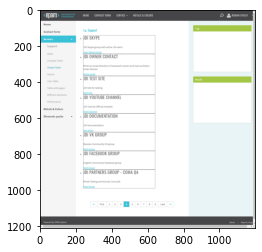

In [30]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Service").click()
        driver.find_element_by_link_text("Search").click()
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='search') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/search.png'))
    pass


- ## Service / User Table

2021-03-02 07:47:09,033 - INFO - dataset:dataset.py:172 - Dataset name: user-table
2021-03-02 07:47:09,033 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 07:47:09,033 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 07:47:10,153 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 07:47:10,153 - INFO - <ipython-input-31-c012404198e9>:<ipython-input-31-c012404198e9>:4 - getting page
2021-03-02 07:47:18,719 - INFO - common:common.py:82 - Window maximized
2021-03-02 07:47:25,723 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/user-table.png
2021-03-02 07:47:26,015 - INFO - dataset:dataset.py:247 - Save html to dataset/html/user-table.html
Number of discovered elements: 366
2021-03-02 07:47:26,036 - INFO - common:common.py:363 - collect features: text
2021-03-02 07:47:29,175 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 07:47:32,410 - INFO - common:common.py:370 - collec

Mouse hover checking:   0%|          | 0/366 [00:00<?, ?it/s]

  0%|          | 0/366 [00:00<?, ?it/s]

2021-03-02 07:50:13,635 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/user-table.parquet
2021-03-02 07:50:13,635 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 07:50:13,635 - INFO - dataset:dataset.py:49 - Leafs set size: 177 (nodes which have no children)
2021-03-02 07:50:13,635 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 07:50:13,635 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 116 (nodes which have leafs as children)
2021-03-02 07:50:13,635 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 07:50:13,635 - INFO - dataset:dataset.py:59 - Nodes with children: 190
2021-03-02 07:50:13,635 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 07:50:13,650 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 07:50:13,650 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 07:50:13,704 -

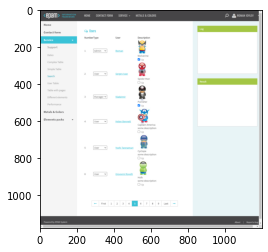

In [31]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Service").click()
        driver.find_element_by_link_text("User Table").click()
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='user-table') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/user-table.png'))
    pass



- ## Service / Table with pages

2021-03-02 07:50:13,882 - INFO - dataset:dataset.py:172 - Dataset name: table-with-pages
2021-03-02 07:50:13,882 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 07:50:13,882 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 07:50:15,023 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 07:50:15,023 - INFO - <ipython-input-32-782f3e3eb4b5>:<ipython-input-32-782f3e3eb4b5>:4 - getting page
2021-03-02 07:50:23,809 - INFO - common:common.py:82 - Window maximized
2021-03-02 07:50:30,819 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/table-with-pages.png
2021-03-02 07:50:31,206 - INFO - dataset:dataset.py:247 - Save html to dataset/html/table-with-pages.html
Number of discovered elements: 309
2021-03-02 07:50:31,237 - INFO - common:common.py:363 - collect features: text
2021-03-02 07:50:33,694 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 07:50:36,331 - INFO - common:comm

Mouse hover checking:   0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

2021-03-02 07:52:36,676 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/table-with-pages.parquet
2021-03-02 07:52:36,691 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 07:52:36,691 - INFO - dataset:dataset.py:49 - Leafs set size: 145 (nodes which have no children)
2021-03-02 07:52:36,691 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 07:52:36,691 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 93 (nodes which have leafs as children)
2021-03-02 07:52:36,691 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 07:52:36,691 - INFO - dataset:dataset.py:59 - Nodes with children: 165
2021-03-02 07:52:36,691 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 07:52:36,691 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 07:52:36,707 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 07:52:36,

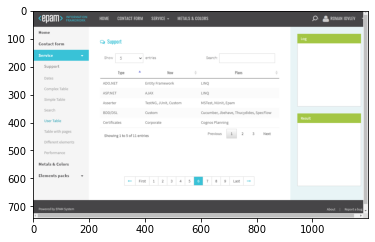

In [32]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Service").click()
        driver.find_element_by_link_text("Table with pages").click()
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='table-with-pages') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/table-with-pages.png'))
    pass


- ## Service / Different elements

2021-03-02 07:52:36,907 - INFO - dataset:dataset.py:172 - Dataset name: different-elemants
2021-03-02 07:52:36,907 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 07:52:36,914 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 07:52:38,016 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 07:52:38,016 - INFO - <ipython-input-33-b121a0bcd038>:<ipython-input-33-b121a0bcd038>:4 - getting page
2021-03-02 07:52:46,437 - INFO - common:common.py:82 - Window maximized
2021-03-02 07:52:53,452 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/different-elemants.png
2021-03-02 07:52:53,700 - INFO - dataset:dataset.py:247 - Save html to dataset/html/different-elemants.html
Number of discovered elements: 289
2021-03-02 07:52:53,716 - INFO - common:common.py:363 - collect features: text
2021-03-02 07:52:55,936 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 07:52:58,345 - INFO - commo

Mouse hover checking:   0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/289 [00:00<?, ?it/s]

2021-03-02 07:54:39,562 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/different-elemants.parquet
2021-03-02 07:54:39,562 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 07:54:39,562 - INFO - dataset:dataset.py:49 - Leafs set size: 131 (nodes which have no children)
2021-03-02 07:54:39,562 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 07:54:39,562 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 92 (nodes which have leafs as children)
2021-03-02 07:54:39,562 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 07:54:39,578 - INFO - dataset:dataset.py:59 - Nodes with children: 159
2021-03-02 07:54:39,578 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 07:54:39,578 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 07:54:39,578 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 07:54:3

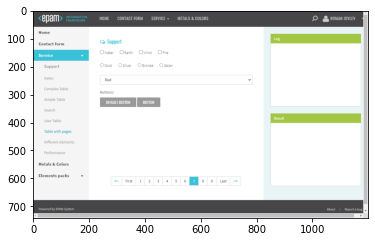

In [33]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Service").click()
        driver.find_element_by_link_text("Different elements").click()
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='different-elemants') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/different-elemants.png'))
    pass


- ## Service / Performance

2021-03-02 07:54:39,774 - INFO - dataset:dataset.py:172 - Dataset name: performance
2021-03-02 07:54:39,774 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 07:54:39,774 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 07:54:40,850 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 07:54:40,850 - INFO - <ipython-input-34-23828f98e130>:<ipython-input-34-23828f98e130>:4 - getting page
2021-03-02 07:54:49,527 - INFO - common:common.py:82 - Window maximized
2021-03-02 07:54:56,541 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/performance.png
2021-03-02 07:54:58,513 - INFO - dataset:dataset.py:247 - Save html to dataset/html/performance.html
Number of discovered elements: 2672
2021-03-02 07:54:58,848 - INFO - common:common.py:363 - collect features: text
2021-03-02 07:55:33,847 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 07:56:16,583 - INFO - common:common.py:370 - co

Mouse hover checking:   0%|          | 0/2672 [00:00<?, ?it/s]

  0%|          | 0/2672 [00:00<?, ?it/s]

2021-03-02 08:40:25,767 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/performance.parquet
2021-03-02 08:40:25,782 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 08:40:25,782 - INFO - dataset:dataset.py:49 - Leafs set size: 2120 (nodes which have no children)
2021-03-02 08:40:25,782 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 08:40:25,782 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 486 (nodes which have leafs as children)
2021-03-02 08:40:25,798 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 08:40:25,798 - INFO - dataset:dataset.py:59 - Nodes with children: 553
2021-03-02 08:40:25,798 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 08:40:25,798 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 08:40:25,798 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 08:40:26,595

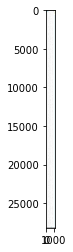

In [34]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Service").click()
        driver.find_element_by_link_text("Performance").click()
        maximize_window(driver=driver)
        sleep(WAIT_TIME_SECONDS)

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='performance') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/performance.png'))
    pass



- ## Angular

2021-03-02 08:56:39,696 - INFO - dataset:dataset.py:172 - Dataset name: angular
2021-03-02 08:56:39,709 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 08:56:39,710 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 08:56:40,839 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 08:56:40,839 - INFO - <ipython-input-39-14d1288f02dd>:<ipython-input-39-14d1288f02dd>:4 - getting page
2021-03-02 08:57:16,842 - INFO - common:common.py:82 - Window maximized
2021-03-02 08:57:31,846 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/angular.png
2021-03-02 08:57:34,816 - INFO - dataset:dataset.py:247 - Save html to dataset/html/angular.html
Number of discovered elements: 6447
2021-03-02 08:57:36,789 - INFO - common:common.py:363 - collect features: text
2021-03-02 08:59:57,524 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 09:03:19,282 - INFO - common:common.py:370 - collect featur

Mouse hover checking:   0%|          | 0/6447 [00:00<?, ?it/s]

  0%|          | 0/6447 [00:00<?, ?it/s]

2021-03-02 11:16:13,971 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/angular.parquet
2021-03-02 11:16:14,003 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 11:16:14,005 - INFO - dataset:dataset.py:49 - Leafs set size: 3249 (nodes which have no children)
2021-03-02 11:16:14,008 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 11:16:14,012 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 1749 (nodes which have leafs as children)
2021-03-02 11:16:14,016 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 11:16:14,018 - INFO - dataset:dataset.py:59 - Nodes with children: 3199
2021-03-02 11:16:14,022 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 11:16:14,029 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 11:16:14,035 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 11:16:15,328 -

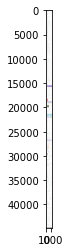

In [39]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Elements packs").click()
        driver.find_element_by_link_text("Angular").click()
        sleep(15.0)
        maximize_window(driver=driver)
        sleep(15.0)

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='angular') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/angular.png'))
    pass



## Bootstarp form

2021-03-02 08:40:27,333 - INFO - dataset:dataset.py:172 - Dataset name: bootstrap-form
2021-03-02 08:40:27,333 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 08:40:27,333 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 08:40:28,466 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 08:40:28,466 - INFO - <ipython-input-36-99363e7ab368>:<ipython-input-36-99363e7ab368>:4 - getting page
2021-03-02 08:40:56,472 - INFO - common:common.py:82 - Window maximized
2021-03-02 08:41:11,474 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/bootstrap-form.png
2021-03-02 08:41:12,154 - INFO - dataset:dataset.py:247 - Save html to dataset/html/bootstrap-form.html
Number of discovered elements: 811
2021-03-02 08:41:12,205 - INFO - common:common.py:363 - collect features: text
2021-03-02 08:41:20,104 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 08:41:28,925 - INFO - common:common.py:

Mouse hover checking:   0%|          | 0/811 [00:00<?, ?it/s]

  0%|          | 0/811 [00:00<?, ?it/s]

2021-03-02 08:51:56,216 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/bootstrap-form.parquet
2021-03-02 08:51:56,231 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 08:51:56,231 - INFO - dataset:dataset.py:49 - Leafs set size: 474 (nodes which have no children)
2021-03-02 08:51:56,231 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 08:51:56,231 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 230 (nodes which have leafs as children)
2021-03-02 08:51:56,231 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 08:51:56,231 - INFO - dataset:dataset.py:59 - Nodes with children: 338
2021-03-02 08:51:56,231 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 08:51:56,231 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 08:51:56,247 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 08:51:56,4

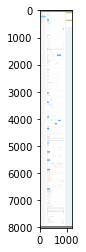

In [36]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Elements packs").click()
        driver.find_element_by_link_text("Bootstrap form").click()
        sleep(15.0)
        maximize_window(driver=driver)
        sleep(15.0)

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='bootstrap-form') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/bootstrap-form.png'))
    pass



## Bootstarp forms

2021-03-02 08:51:56,812 - INFO - dataset:dataset.py:172 - Dataset name: bootstrap-forms
2021-03-02 08:51:56,812 - INFO - dataset:dataset.py:181 - Create directories to save the dataset
2021-03-02 08:51:56,816 - INFO - dataset:dataset.py:212 - Creating driver
2021-03-02 08:51:57,910 - INFO - dataset:dataset.py:219 - Chrome web driver is created
2021-03-02 08:51:57,910 - INFO - <ipython-input-37-5a07cc29f362>:<ipython-input-37-5a07cc29f362>:4 - getting page
2021-03-02 08:52:24,029 - INFO - common:common.py:82 - Window maximized
2021-03-02 08:52:39,037 - INFO - dataset:dataset.py:243 - Save color screenshot to dataset/images/bootstrap-forms.png
2021-03-02 08:52:39,327 - INFO - dataset:dataset.py:247 - Save html to dataset/html/bootstrap-forms.html
Number of discovered elements: 312
2021-03-02 08:52:39,359 - INFO - common:common.py:363 - collect features: text
2021-03-02 08:52:41,865 - INFO - common:common.py:366 - collect features: parent_id
2021-03-02 08:52:44,565 - INFO - common:common.

Mouse hover checking:   0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

2021-03-02 08:54:53,009 - INFO - dataset:dataset.py:256 - Save parquet to dataset/df/bootstrap-forms.parquet
2021-03-02 08:54:53,025 - INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-03-02 08:54:53,025 - INFO - dataset:dataset.py:49 - Leafs set size: 151 (nodes which have no children)
2021-03-02 08:54:53,025 - INFO - dataset:dataset.py:52 - count number of references to leafs
2021-03-02 08:54:53,025 - INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 92 (nodes which have leafs as children)
2021-03-02 08:54:53,025 - INFO - dataset:dataset.py:57 - count num children for each node
2021-03-02 08:54:53,025 - INFO - dataset:dataset.py:59 - Nodes with children: 162
2021-03-02 08:54:53,025 - INFO - dataset:dataset.py:62 - sum of children widths, heights, counts
2021-03-02 08:54:53,039 - INFO - dataset:dataset.py:67 - Sum of children widths
2021-03-02 08:54:53,039 - INFO - dataset:dataset.py:71 - Sum of children hights
2021-03-02 08:54:53,0

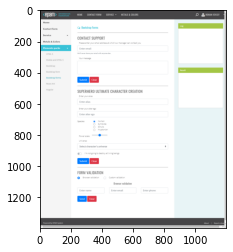

In [37]:
class JDIDatasetBuilder(DatasetBuilder):
    
    def setUp(self, driver):
        self.logger.info(f'getting page')
        driver.get(SITE_ROOT)
        
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        
        driver.find_element_by_link_text("Elements packs").click()
        driver.find_element_by_link_text("Bootstrap forms").click()
        sleep(15.0)       
        maximize_window(driver=driver)
        sleep(15.0)

with JDIDatasetBuilder(url=SITE_ROOT, dataset_name='bootstrap-forms') as builder:
    elements_df = builder.dataset
    plt.imshow(plt.imread('dataset/images/bootstrap-forms.png'))
    pass



In [38]:
print('Elapsed time:', datetime.now() - START_TS)

Elapsed time: 2:07:21.747383
